In [ ]:
# Link to Web App: https://news-articles-clustering.herokuapp.com/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set()
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
# Read in the telegraph_articles
telegraph_articles = pd.read_csv('./telegraph_articles.csv')

In [4]:
# Read in the newyorktimes_articles
newyorktimes_articles = pd.read_csv('./newyorktimes_articles.csv')

In [5]:
# Read in the nytimes_articles
foxnews_articles = pd.read_csv('./foxnews_articles.csv')

In [6]:
# Read in the abcnews_articles
abcnews_articles = pd.read_csv('./abcnews_articles.csv')

In [7]:
# Combine articles to one dataframe
articles = pd.concat([telegraph_articles, newyorktimes_articles, foxnews_articles, abcnews_articles])

In [8]:
articles_copy = articles.copy()

In [9]:
articles.head(5)

,url,category,heading,article
0,https://www.telegraph.co.uk/politics/2021/04/0...,politics,NaN,NaN
1,https://www.telegraph.co.uk/politics/2021/03/2...,politics,"\nJennifer Arcuri pursuing 'vendetta', say fri...",Jennifer Arcuri is pursuing a “vendetta” again...
2,https://www.telegraph.co.uk/news/2021/02/02/ur...,politics,\nWhy Ursula von der Leyen won't quit over Ast...,Ursula von der Leyen has no plans to quit afte...
3,https://www.telegraph.co.uk/news/2021/01/29/ow...,politics,\nOwen Paterson on the agony of his wife's sui...,When the police told Owen Paterson his wife Ro...
4,https://www.telegraph.co.uk/politics/2021/03/2...,politics,"\nRaise school starting age to seven, Scottish...",Children in Scotland should start school at th...


In [10]:
# Look at the shape of the data
articles.shape

(493, 4)

### Data Exploration

In [11]:
# Check for null values
articles.isnull().sum()

url          0
category     0
heading     60
article     26
dtype: int64

#### Since we only need the category and the article, we'll drop all other columns except the two then drop the rows with null values in the remaining two columns

In [12]:
# Drop unnecessary columns
articles = articles.drop(['heading'], axis=1)
articles_copy = articles_copy.drop(['heading'], axis=1)

# Drop null rows in the remaining rows
articles = articles.dropna()
articles_copy = articles_copy.dropna()

In [13]:
# Reset the indices of the articles
articles = articles.reset_index(drop=True)

In [14]:
articles.head()

,url,category,article
0,https://www.telegraph.co.uk/politics/2021/03/2...,politics,Jennifer Arcuri is pursuing a “vendetta” again...
1,https://www.telegraph.co.uk/news/2021/02/02/ur...,politics,Ursula von der Leyen has no plans to quit afte...
2,https://www.telegraph.co.uk/news/2021/01/29/ow...,politics,When the police told Owen Paterson his wife Ro...
3,https://www.telegraph.co.uk/politics/2021/03/2...,politics,Children in Scotland should start school at th...
4,https://www.telegraph.co.uk/politics/2021/03/2...,politics,Conservative MPs are calling on Boris Johnson ...


<AxesSubplot:>

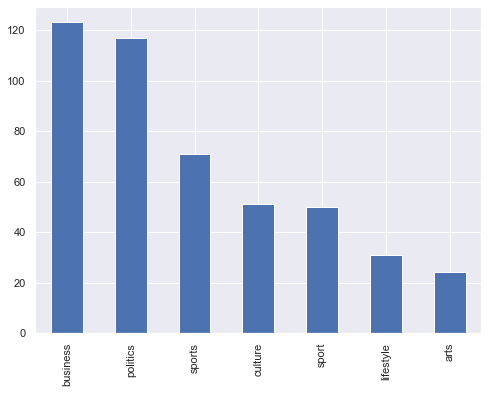

In [15]:
# Look at the distribution of categories in the articles
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles['category'].value_counts().plot(kind='bar', ax=ax)

In [16]:
# Combine culture, arts, lifestyle and sport and sports
culture_arts_lifestyle = ['culture', 'arts', 'lifestyle']
sports = ['sport', 'sports']

articles['category'] = articles['category'].apply(lambda x: 'culture/arts/lifestyle 'if x in culture_arts_lifestyle else('sports' if x in sports else(x)))

<AxesSubplot:>

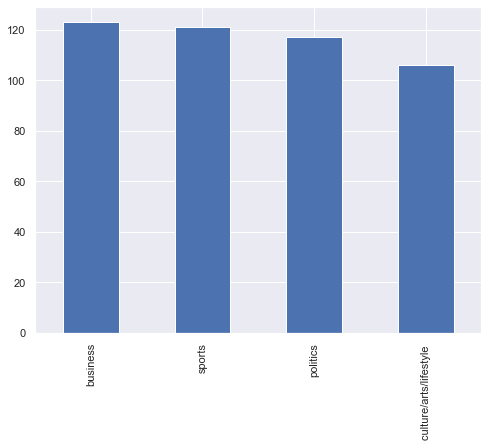

In [17]:
# Look at the distribution of new categories in the articles
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles['category'].value_counts().plot(kind='bar', ax=ax)

### Data Preprocessing

In [18]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS = stopwords.words('english')

In [19]:
# Dictionary mapping word contractions to their full words
contractions = { 
    "ain't": "are not","'s":" is","aren't": "are not",
     "can't": "cannot","can't've": "cannot have",
     "'cause": "because","could've": "could have","couldn't": "could not",
     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
     "hasn't": "has not","haven't": "have not","he'd": "he would",
     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
     "it'd": "it would","it'd've": "it would have","it'll": "it will",
     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
     "mayn't": "may not","might've": "might have","mightn't": "might not", 
     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
     "mustn't've": "must not have", "needn't": "need not",
     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
     "she'll": "she will", "she'll've": "she will have","should've": "should have",
     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
     "there'd've": "there would have", "they'd": "they would",
     "they'd've": "they would have","they'll": "they will",
     "they'll've": "they will have", "they're": "they are","they've": "they have",
     "to've": "to have","wasn't": "was not","we'd": "we would",
     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
     "what'll've": "what will have","what're": "what are", "what've": "what have",
     "when've": "when have","where'd": "where did", "where've": "where have",
     "who'll": "who will","who'll've": "who will have","who've": "who have",
     "why've": "why have","will've": "will have","won't": "will not",
     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
     "y'all'd've": "you all would have","y'all're": "you all are",
     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
     "you'll": "you will","you'll've": "you will have", "you're": "you are",
     "you've": "you have"
}

In [20]:
# Remove punctutation marks, stopwords, emojis, urls, convert to lowercase, expand contractions 
def preprocess_article(article):
    res_article = []
    lemmatizer = WordNetLemmatizer()
    
    for word in article.split():        
        
        # Expand Contractions
        word = contractions.get(word.lower(), word)
        
        # Remove stopwords
        if word not in STOPWORDS:
            
            # Remove url
            word = re.sub(r'http\S+', '', word)
    
            emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
            word = emoji_clean.sub(r'', word)
            
             # Remove punctuation
            word = re.sub(r'[^\w\s]', '', word)
            
            # Convert to lowercase
            word = word.lower()
            
            # Lemmatize the word
            word = lemmatizer.lemmatize(word, pos='v')
        
            if word != '':
                res_article.append(word)
    

    return ' '.join([word for word in res_article]) 

In [61]:
articles['article'] = articles['article'].apply(lambda x: preprocess_article(x))

In [62]:
articles.head()

,url,category,article,clusters
0,https://www.telegraph.co.uk/politics/2021/03/2...,politics,jennifer arcuri pursue vendetta boris johnson ...,0
1,https://www.telegraph.co.uk/news/2021/02/02/ur...,politics,ursula von der leyen plan quit last weeks coro...,4
2,https://www.telegraph.co.uk/news/2021/01/29/ow...,politics,police tell owen paterson wife rise find shrop...,1
3,https://www.telegraph.co.uk/politics/2021/03/2...,politics,children scotland start school age seven rathe...,0
4,https://www.telegraph.co.uk/politics/2021/03/2...,politics,conservative mps call boris johnson consider l...,0


### Further Data Exploration

In [63]:
from nltk.probability import FreqDist

In [64]:
article_tokens = [word for article in articles['article'] for word in article.split()]
fdist = FreqDist(article_tokens)

<AxesSubplot:>

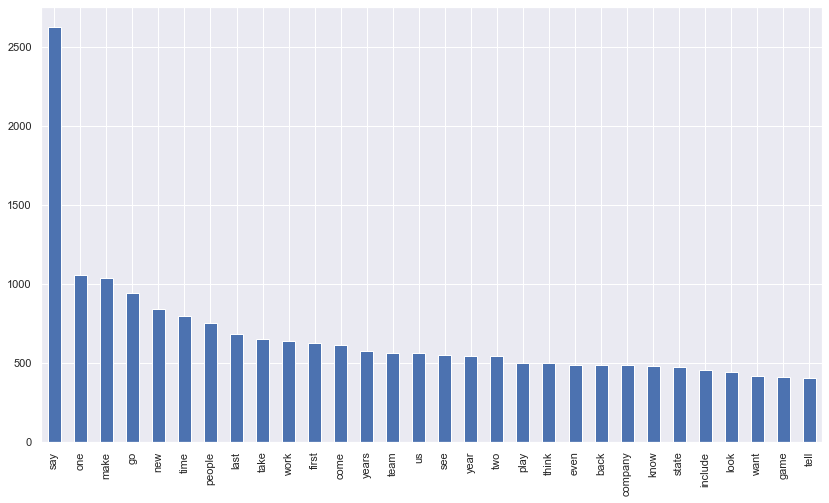

In [65]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()

pd.Series(dict(fdist.most_common(30))).plot(kind='bar', ax=ax)

In [66]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [67]:
def display_cloud(label):
    plt.subplots(figsize=(13,13))
    text = articles[articles['category']==label]["article"].tolist()
    wc = WordCloud(
      stopwords=STOPWORDS,
      background_color='black',
      colormap='Blues',
      collocations=False,
      width=1800,
      height=800,
    )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(label,fontsize=24)
    plt.show()

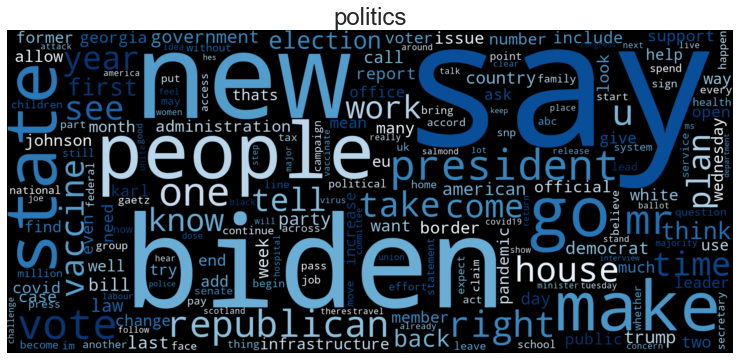

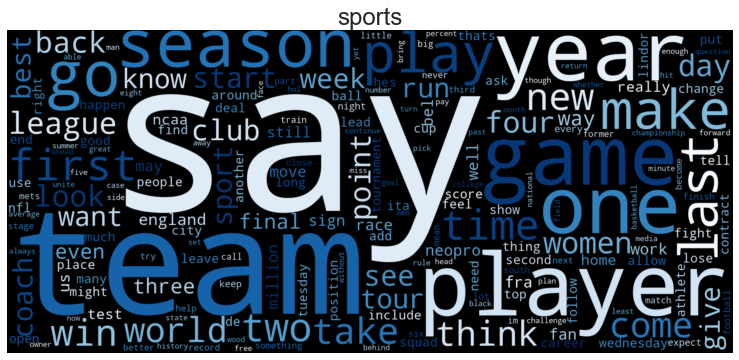

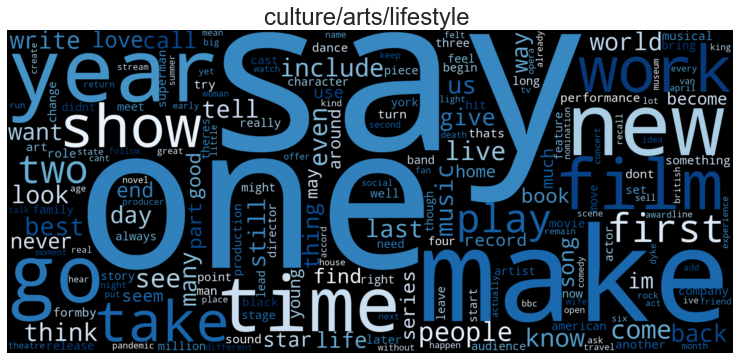

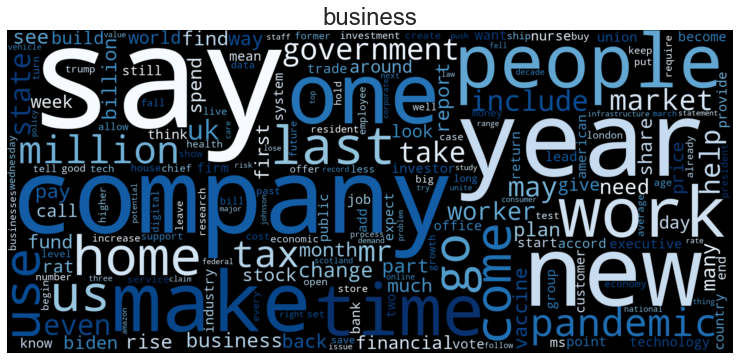

In [68]:
for category in articles['category'].unique():
    display_cloud(category)

### Feature Engineering

In [29]:
#TF IDF for article column
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_article = tfidf_vectorizer.fit_transform(articles['article'])

In [31]:
pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

In [32]:
#tf-idf output vectors
from sklearn.decomposition import PCA 

In [33]:
tfidf_article.toarray().shape

(467, 26926)

In [34]:
tfidf_pca = PCA(n_components = 2) 
tfidf_pca_comp = tfidf_pca.fit_transform(tfidf_article.toarray())

In [35]:
tfidf_pca_comp.shape

(467, 2)

In [36]:
pickle.dump(tfidf_pca, open('tfidf_pca.pkl', 'wb'))

In [37]:
from sklearn.cluster import KMeans

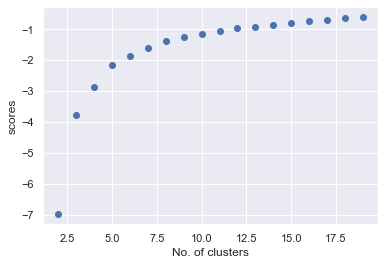

In [38]:
clusters=[]
kmeans_scores=[]

K = range(2, 20)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(tfidf_pca_comp)
    kmeans_scores.append(k_means.score(tfidf_pca_comp))
    clusters.append(k)
plt.scatter(clusters,kmeans_scores)
plt.xlabel("No. of clusters")
plt.ylabel("scores")
plt.show()

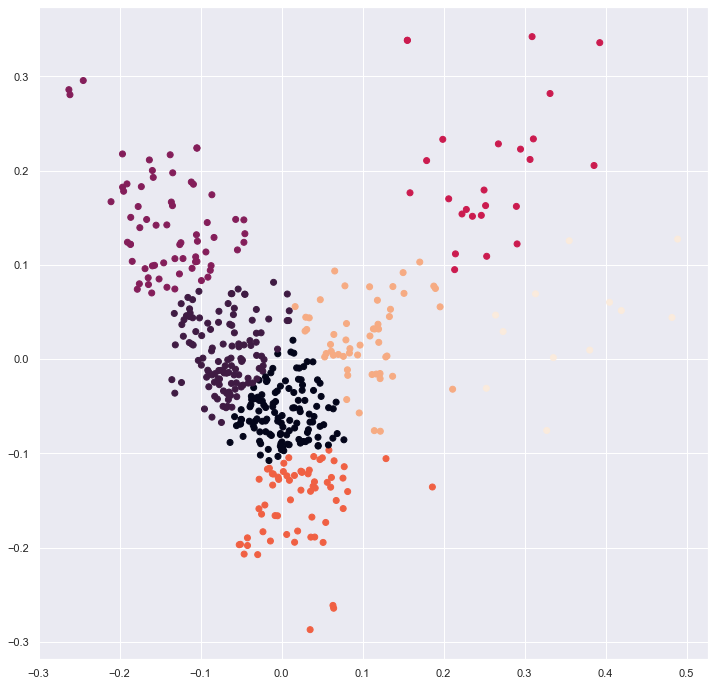

In [39]:
k_means = KMeans(n_clusters=7)
k_means.fit(tfidf_pca_comp)
pred=k_means.predict(tfidf_pca_comp)
plt.figure(figsize=(12,12))
plt.scatter(tfidf_pca_comp[:,0],tfidf_pca_comp[:,1],c=pred)
# sns.scatterplot(x=tfidf_pca_comp[:,0], y=tfidf_pca_comp[:,0], hue=pred)
plt.show()

In [40]:
import pickle

In [41]:
# Save the kmeans model for deployment
pickle.dump( k_means, open('kmeans_model.pkl', 'wb'))

In [42]:
articles['clusters'] = pred
articles_copy['clusters'] = pred

articles.head()

,url,category,article,clusters
0,https://www.telegraph.co.uk/politics/2021/03/2...,politics,jennifer arcuri pursue vendetta boris johnson ...,0
1,https://www.telegraph.co.uk/news/2021/02/02/ur...,politics,ursula von der leyen plan quit last weeks coro...,4
2,https://www.telegraph.co.uk/news/2021/01/29/ow...,politics,when police tell owen paterson wife rise find ...,1
3,https://www.telegraph.co.uk/politics/2021/03/2...,politics,children scotland start school age seven rathe...,0
4,https://www.telegraph.co.uk/politics/2021/03/2...,politics,conservative mps call boris johnson consider l...,0


In [43]:
articles['clusters'].unique()

array([0, 4, 1, 5, 2, 6, 3])

In [44]:
#Articles in cluster 0
articles[articles['clusters'] == 0][['category', 'article', 'clusters']]

,category,article,clusters
0,politics,jennifer arcuri pursue vendetta boris johnson ...,0
3,politics,children scotland start school age seven rathe...,0
4,politics,conservative mps call boris johnson consider l...,0
9,politics,its clear nicola sturgeon damage goods days nu...,0
10,politics,in list britains top tourist attractions might...,0
...,...,...,...
448,politics,i texas state troopers onboard tactical marine...,0
452,politics,target violence school preventable warn sign i...,0
457,politics,authorities believe massive allegedly carry ru...,0
462,politics,rep matt gaetz rfla tuesday deny inappropriate...,0


<AxesSubplot:>

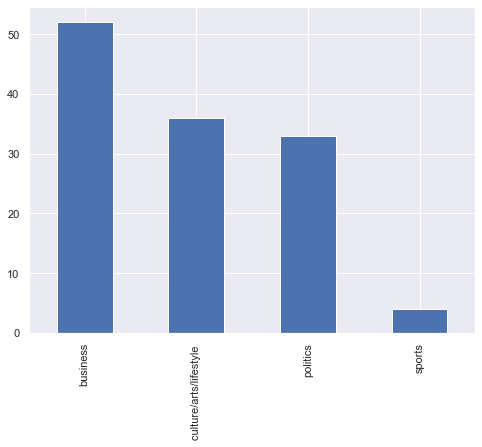

In [45]:
# Look at the distribution of categories in the articles in cluster 0
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 0]['category'].value_counts().plot(kind='bar', ax=ax)

In [46]:
#Articles in cluster 1
articles[articles['clusters'] == 1][['category', 'article', 'clusters']]

,category,article,clusters
2,politics,when police tell owen paterson wife rise find ...,1
12,sports,the achievement rachael blackmore rid six winn...,1
13,culture/arts/lifestyle,tell story americans hide population itinerant...,1
14,sports,follow todays race tip get latest bet offer fr...,1
15,sports,the grand national back it best know steeplech...,1
...,...,...,...
366,sports,owner daniel snyders family gain complete cont...,1
388,business,new york the trajectory conservative network n...,1
400,business,silver spring md maybe luka doncic rookie card...,1
424,business,dubai unite arab emirates it scene reminiscent...,1


<AxesSubplot:>

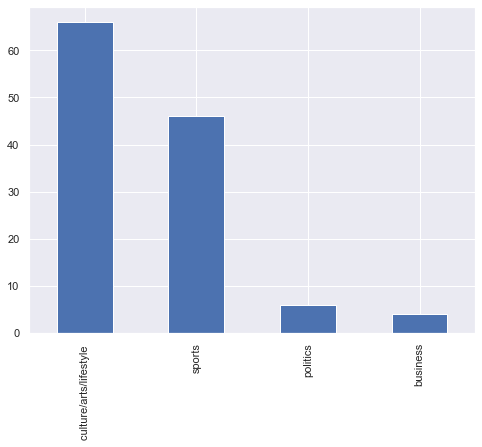

In [47]:
# Look at the distribution of categories in the articles in cluster 1
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 1]['category'].value_counts().plot(kind='bar', ax=ax)

In [48]:
#Articles in cluster 2
articles[articles['clusters'] == 2][['category', 'article', 'clusters']]

,category,article,clusters
21,sports,dinara safina stand front bathroom mirror look...,2
24,sports,the 2021 formula one season underway bang argu...,2
25,sports,barely blink eye lowerleague club allow back t...,2
29,sports,england paranoid think players ashley giles te...,2
30,sports,gareth southgate reveal weekend would keep tou...,2
33,sports,comprise 19 team 13 different countries five c...,2
34,sports,by far compel difference ireland new zealand 1...,2
35,sports,as teenage cricket nut essex fan july 27 1990 ...,2
36,sports,the referee know it coach know it players know...,2
37,sports,for jimmy white renewal rivalries stephen hend...,2


<AxesSubplot:>

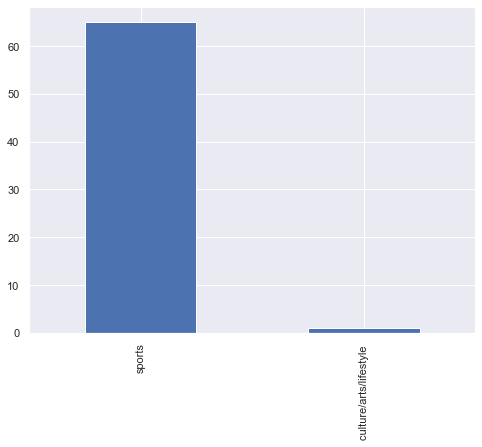

In [49]:
# Look at the distribution of categories in the articles in cluster 2
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 2]['category'].value_counts().plot(kind='bar', ax=ax)

In [50]:
#Articles in cluster 3
articles[articles['clusters'] == 3][['category', 'article', 'clusters']]

,category,article,clusters
188,politics,washington president biden say wednesday would...,3
189,politics,washington rita hart democrat run congress 202...,3
230,business,company georgia republicans rush pass law rest...,3
302,politics,while much media hail joe biden 21stcentury fd...,3
305,politics,two national group intervene statelevel lawsui...,3
314,politics,express support idea mlb allstar game move atl...,3
320,politics,the 19 trillion covid relief bill get attentio...,3
335,politics,democrat rita hart announce withdraw challenge...,3
346,politics,face mount pressure delta air line cocacolas c...,3
372,sports,president joe biden speak night major league b...,3


<AxesSubplot:>

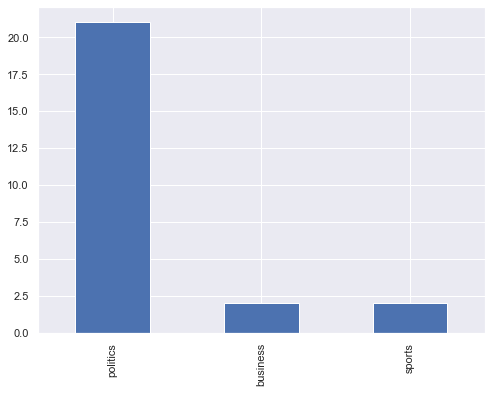

In [51]:
# Look at the distribution of categories in the articles in cluster 3
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 3]['category'].value_counts().plot(kind='bar', ax=ax)

In [52]:
#Articles in cluster 4
articles[articles['clusters'] == 4][['category', 'article', 'clusters']]

,category,article,clusters
1,politics,ursula von der leyen plan quit last weeks coro...,4
5,politics,more 15 million fewer scots would vaccinate sn...,4
7,politics,it extraordinary story european commission fin...,4
18,politics,jeanclaude juncker attack ursula von der leyen...,4
81,business,limit high street footfall reduce loan book un...,4
82,business,buy weakness suggest last month vaccine maker ...,4
117,business,one governments famous build turn plush london...,4
120,business,households would automatically refund overpaym...,4
121,business,in week uk government grudgingly award minuscu...,4
125,business,royal mail reward investors pandemic payout sp...,4


<AxesSubplot:>

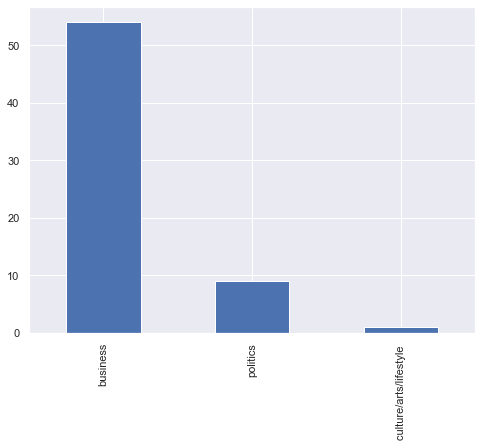

In [53]:
# Look at the distribution of categories in the articles in cluster 4
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 4]['category'].value_counts().plot(kind='bar', ax=ax)

In [54]:
#Articles in cluster 5
articles[articles['clusters'] == 5][['category', 'article', 'clusters']]

,category,article,clusters
6,politics,the scottish labour party lose lastminute bid ...,5
8,politics,women majority population vote count obviously...,5
23,politics,ever since last year debate rag extent experie...,5
162,politics,donald trump daughterinlaw criticise facebook ...,5
182,politics,use everyday social activities pandemic ease w...,5
187,politics,delano calif jill biden first lady travel cali...,5
205,business,taxpayers receive unemployment benefit last ye...,5
217,sports,washington justices across ideological spectru...,5
218,sports,the scene familiar its practically banal damia...,5
222,business,marilyn reece lead bakery clerk kroger batesvi...,5


<AxesSubplot:>

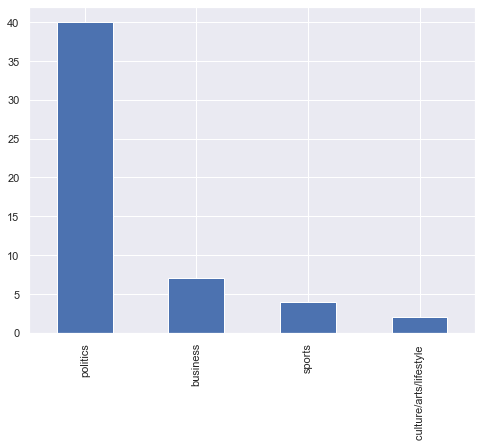

In [55]:
# Look at the distribution of categories in the articles in cluster 5
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 5]['category'].value_counts().plot(kind='bar', ax=ax)

In [56]:
#Articles in cluster 6
articles[articles['clusters'] == 6][['category', 'article', 'clusters']]

,category,article,clusters
161,politics,joe biden defend proposal fund 2 trillion 16tr...,6
185,politics,washington it 40 years since president ronald ...,6
249,business,president bidens ambitious plan increase corpo...,6
259,politics,speak outside pittsburgh today president biden...,6
260,politics,washington in 2017 donald j trump announce lar...,6
262,politics,washington republicans capitol hill begin line...,6
274,politics,hold first meet thursday one week full group c...,6
303,politics,hey finally infrastructure week its sexiest to...,6
328,politics,president wednesday unveil call roughly 2 tril...,6
403,business,washington americans broadly supportive presid...,6


<AxesSubplot:>

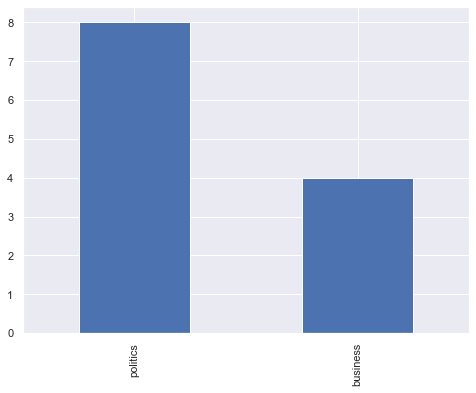

In [57]:
# Look at the distribution of categories in the articles in cluster 6
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 6]['category'].value_counts().plot(kind='bar', ax=ax)

In [58]:
articles_copy.isnull().sum()

url         0
category    0
article     0
clusters    0
dtype: int64

In [59]:
articles.isnull().sum()

url         0
category    0
article     0
clusters    0
dtype: int64

In [60]:
articles_copy.to_csv('clustered_articles.csv', index=False)